In [1]:
import ROOT
import narf
import pandas as pd
import h5py 
import hist
import hdf5plugin
import math
import boost_histogram as bh
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import OrderedDict
import mplhep as hep
from IPython.display import Image
import wremnants
import hist

Welcome to JupyROOT 6.28/02


In [20]:
from utilities import boostHistHelpers as hh,common,output_tools,logging

# 5/5/23 rerunning bootstrap with proper sumw & sumw2 

In [2]:
f2 = h5py.File("templatesTest3.hdf5","r")
results2 = narf.ioutils.pickle_load_h5py(f2["results"])

#constants
process = 'ZmumuPostVFP'
#V ='Z'
lumi    = 16.8  #results['dataPostVFP']["lumi"]
xsec    = results[process]["dataset"]["xsec"]
weights = results[process]["weight_sum"]
C       = lumi*1000*xsec/weights


Hdata_obs = C*results2['ZmumuPostVFP']['output']['signal_nominal'].get()[sum,sum,:,:,:,sum]

sumw  = Hdata_obs[...,1].values().ravel()
sumw2 = Hdata_obs[...,1].variances().ravel() #single charge

{'signal_nominal': <narf.ioutils.H5PickleProxy object at 0x7f97233326b0>, 'signal_mass': <narf.ioutils.H5PickleProxy object at 0x7f953bc421a0>}


# 5/3/23, 5/4/23 creating mirroring function for boost histogram.

Some systematics do not contain down/up variations. These must be created by adding an axis to the boost histogram. The down variation is defined as nominal/variation and the up variation as variation/nominal

def mirrorHisto(nom,var):
    '''
    Parameters
    ==========
    nom: nominal boost histogram
    var: boost histogram corresponding to systematic variation
    Returns
    =======
    Mirrored Histogram: Boost histogram with new two dimensional axis labeled downUpVar. Index '0' corresponds to 
    'down' variation defined as nom/var and index '1' corresponds to 'up' variation defined as var/nom. 
    0/0 division is taken to be 1.
    '''
    downup_axis = common.down_up_axis
    down = hh.divideHists(nom,var)
    up = hh.divideHists(var,nom)
    data = np.stack([down,up],axis=-1)
    new_histo = hist.Hist(*nom.axes,downup_axis, name=var.name, data=data, storage = hist.storage.Weight())
    return new_histo


#Using random histograms to test function
f = h5py.File("templatesTest3.hdf5","r")
results = narf.ioutils.pickle_load_h5py(f["results"])

H1 = results['ZmumuPostVFP']['output']['signal_nominal'].get()[...,-1]
H2 = results['ZmumuPostVFP']['output']['signal_nominal'].get()[...,0]


mirrorHisto(H1,H2)

# 5/2/23 adding a poisson distribution to each individual bin with mu set to the number of events in that bin

#File imports
f2 = h5py.File("templatesTest3.hdf5","r")
results = narf.ioutils.pickle_load_h5py(f2["results"])

#constants
process = 'ZmumuPostVFP'
V ='Z'
lumi    = 16.8  #results['dataPostVFP']["lumi"]
xsec    = results[process]["dataset"]["xsec"]
weights = results[process]["weight_sum"]
C       = lumi*1000*xsec/weights

Hdata_obs = C*results['ZmumuPostVFP']['output']['signal_nominal'].get()[sum,sum,:,:,:,sum]
data_obs  = Hdata_obs.to_numpy()[0][...,1].ravel()

np.random.seed(3)
pd.Series(data_obs).apply(lambda x: x+np.random.poisson(lam=x))

# 5/1/23 working on combining mass pull for multiple fits using bootstrap method. 

Welcome to JupyROOT 6.28/02
 FCN=47.2822 FROM MIGRAD    STATUS=CONVERGED      68 CALLS          69 TOTAL
                     EDM=1.53938e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.61805e+00   3.26376e-01   1.26374e-03   6.33290e-05
   2  Mean        -2.02080e-01   1.21482e-01   5.79539e-04   2.39168e-04
   3  Sigma        1.19583e+00   8.83296e-02   9.54558e-05   1.33131e-03
                               ERR DEF= 0.5


Info in <TCanvas::Print>: png file mass_pull_bootstrap.png has been created


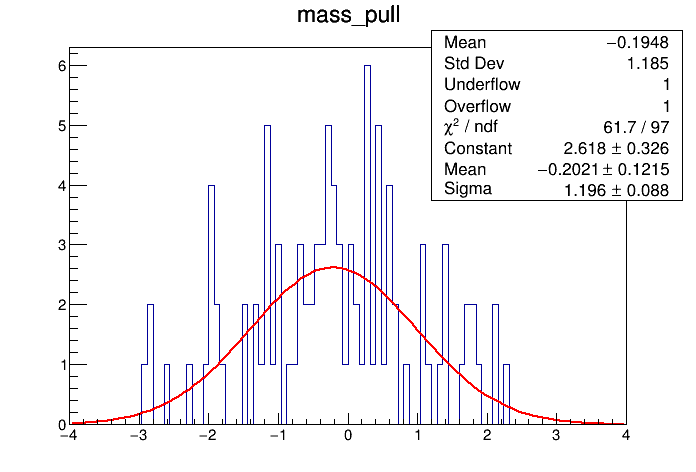

In [1]:
import ROOT
from IPython.display import Image

hists = {}
canvs = {}
hpull = ROOT.TH1D("mass_pull","mass_pull", 100, -4.,4.)
canv = ROOT.TCanvas('mass','mass')
ROOT.gStyle.SetOptStat(111100)


hists['mass']=hpull
canvs['mass']=canv
for ifile in range(100):
    fIntoy = ROOT.TFile.Open('../Fit/FitRes/fit_Wlike_iteration_{}_bootstrap.root'.format(ifile))
    fitresultstoy = fIntoy.Get('fitresults')
    for ev in fitresultstoy:
        for key , hist in hists.items():
            par = getattr(ev,key)
            par_err = getattr(ev,key+'_err')
            hist.Fill(par/par_err)
ROOT.gStyle.SetOptFit(1)
for i,c in canvs.items():
    c.cd()
    hists[i].Fit('gaus','L')
    hists[i].Draw()
    c.SaveAs('{}_bootstrap.png'.format(hists[i].GetName()))
    
Image("mass_pull_bootstrap.png")

Welcome to JupyROOT 6.28/02
 FCN=30.8872 FROM MIGRAD    STATUS=CONVERGED      69 CALLS          70 TOTAL
                     EDM=3.15997e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     4.93682e+00   6.04649e-01   1.90951e-03  -8.87646e-06
   2  Mean        -5.90000e-02   8.08095e-02   3.12633e-04   1.42048e-10
   3  Sigma        8.08095e-01   5.71370e-02   7.44560e-05  -8.62364e-04
                               ERR DEF= 0.5


Info in <TCanvas::Print>: png file mass_pull_bootstrapBBB.png has been created


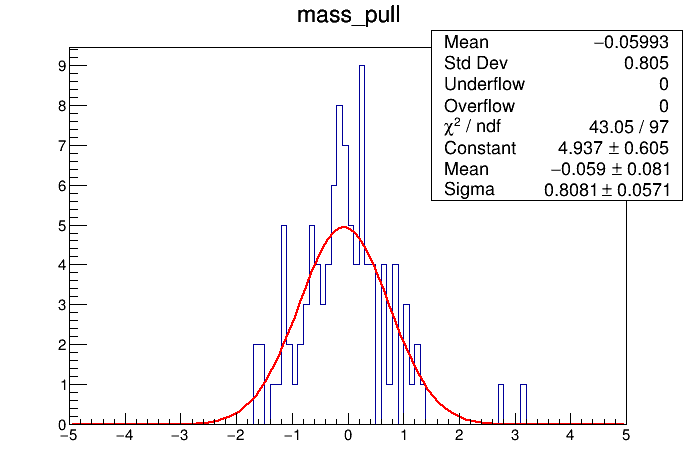

In [1]:
import ROOT
from IPython.display import Image

hists = {}
canvs = {}
hpull = ROOT.TH1D("mass_pull","mass_pull", 100, -5.,5.)
canv = ROOT.TCanvas('mass','mass')
ROOT.gStyle.SetOptStat(111100)


hists['mass']=hpull
canvs['mass']=canv
for ifile in range(100):
    fIntoy = ROOT.TFile.Open('../Fit/FitRes/fit_Wlike_iteration_{}_bootstrapBBB.root'.format(ifile))
    fitresultstoy = fIntoy.Get('fitresults')
    for ev in fitresultstoy:
        for key , hist in hists.items():
            par = getattr(ev,key)
            par_err = getattr(ev,key+'_err')
            hist.Fill(par/par_err)
ROOT.gStyle.SetOptFit(1)
for i,c in canvs.items():
    c.cd()
    hists[i].Fit('gaus','L')
    hists[i].Draw()
    c.SaveAs('{}_bootstrapBBB.png'.format(hists[i].GetName()))
    
Image("mass_pull_bootstrapBBB.png")

Welcome to JupyROOT 6.28/02
 FCN=22.5797 FROM MIGRAD    STATUS=CONVERGED      59 CALLS          60 TOTAL
                     EDM=7.87923e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.00975e+00   6.13560e-01   1.67086e-03  -1.99257e-04
   2  Mean        -3.30000e-02   7.96324e-02   2.63442e-04   4.07943e-09
   3  Sigma        7.96324e-01   5.62999e-02   6.35774e-05  -4.04194e-02
                               ERR DEF= 0.5


Info in <TCanvas::Print>: png file mass_pull.png has been created


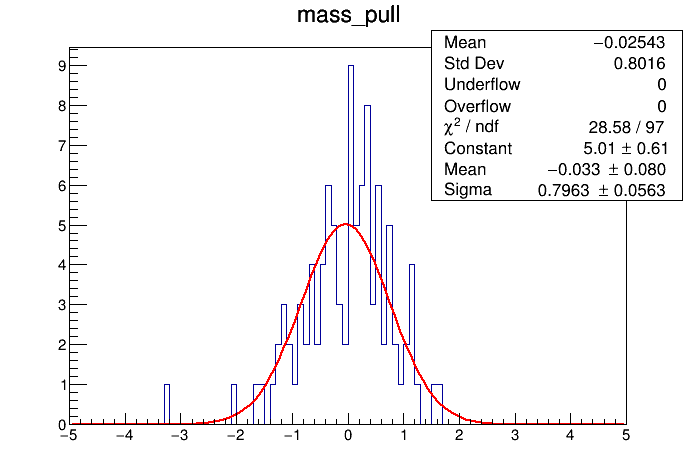

In [1]:
import ROOT
from IPython.display import Image

hists = {}
canvs = {}
hpull = ROOT.TH1D("mass_pull","mass_pull", 100, -5.,5.)
canv = ROOT.TCanvas('mass','mass')
ROOT.gStyle.SetOptStat(111100)


hists['mass']=hpull
canvs['mass']=canv
for ifile in range(100):
    fIntoy = ROOT.TFile.Open('../Fit/FitRes/fit_Wlike_iteration_{}.root'.format(ifile))
    fitresultstoy = fIntoy.Get('fitresults')
    for ev in fitresultstoy:
        for key , hist in hists.items():
            par = getattr(ev,key)
            par_err = getattr(ev,key+'_err')
            hist.Fill(par/par_err)
ROOT.gStyle.SetOptFit(1)
for i,c in canvs.items():
    c.cd()
    hists[i].Fit('gaus','L')
    hists[i].Draw()
    c.SaveAs('{}.png'.format(hists[i].GetName()))
    
Image("mass_pull.png")